# GGOR solution, steady state

@TO 2020-10-31

## Introduction
The GGOR aims to simulate simultanically time series of the average head in cross sections through mulitple, even large numbers of parcels bounded by ditches perpendicular to the plane of the cross sections. The total set of parcels and hence, cross sections, characterizes a given region in the country, usually one or more polder systems.

The theory is described in a separate document. This document together with the code and example notebooks can be found on github (github, Olsthoorn, GGOR) should suffice to locate it. 

The mentioned cross sections can be simulated both analytically and numerially (using MODFLOW). The analytical and numerical solutions can also be applied to simuate a steady-state situation. This allows us to verify the the code, at least for the steady-state case.

The GGOR python project comprises two modules `ggor_analytial.py` and `gg_modfly.py`. The first one contains the code required to analytically simulate the groundwater in single and two-layer aquifer systems, while the second coprises the code to simulate the two layer aquifer system numerically using MODFLOW.

The data of the parcel properties are normally given by shapefile in which each record holds the properties of a parcel, which is handy converted into a pandas.DataFrame for further use. For the current verification of the steady-state solution, this pandas.DataFrame needs to be only one record long. We'll define it directy in this notebook as testdata.

The time-varying data are also given as a pandas.DataFrame, whose index has pd.TimeStamps that represent true dates and times and whose columns contain the precipitation and evapotranspiration. For the current steadt-state example, only one record is required. We will generate this one-line pandas DataFrame directly in this notebook for use in the testing.

In this notbook, we will directly use python functions that implement the various solutions. Theses functions are in the modules `ggor_analytical.py` and `gg_modflow.py` respectively. In anohter notebook, the analytic solutions for the single-layer case are directly implemented and shown to work. The analytic 2-layer solution is only described in the mentioned documentation, but is used in the current notebook.

In the current notebook, we will verify the steady state outcomes of

1. The single layer solution without regional underlying aquifer.
2. The single layer solution with regional underlying aquifer with given head.
3. The single layer solution with regional underlying aquifer with given seepage.
4. The two-layer solution with given reginal seepage.
5. The numeric MODFLOW solution with given regional seepage.




# The expressions for the basic single-layer solutions without and with an underlying regional aquifer with prescribed head

The single layer solution without underlying regional aquifer is

$$h - h_{LR} =  \frac{N\left(b^2 - x^2\right)}{2 kD} + N b \frac{w}{D}$$

and the one with underlying aquifer is

$$h-\phi = Nc - \frac{b}{\lambda}\left(Nc - \left(h_{LR}-\phi\right)\right)\Lambda
\left(\frac{\cosh\frac x \lambda}{\sinh\frac b \lambda}\right)$$
with
$$\Lambda=\frac{1}{\frac{b}{\lambda}\mbox{ctanh}\frac{b}{\lambda}+\frac{b/c}{D/w}}$$

The expressions for the analytical multi-layer solutions are given in the theory. And, of course, the numerical solution can't be captured in a single expression.

# Imports

In [601]:
# Modules
import numpy as np
import pandas as pd
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import flopy.utils.binaryfile as bf
import pdb
import os

# These lines need to be adapted to the ones on your computer
PYTHON = os.path.expanduser('~/GRWMODELS/python/')
TOOLS  = os.path.expanduser('~/GRWMODELS/python/tools')
HOME = os.path.join(PYTHON, 'GGOR')

import sys
sys.path.insert(0, TOOLS)
sys.path.insert(0, PYTHON)

# Note that TOOLS has some modules that are required
# tools.fmd.mfgrid
# tools.knmi

# GGOR assumes a fixed directory structure that is partly represente here
import GGOR.src.numeric.gg_mflow as gn          # Numerical solution
import GGOR.src.analytic.ggor_analytical as ga  # Analytical solutions

# Handy if one edits the previous modules, reloading them is required
from importlib import reload

# Matter of taste
matplotlib.rc('font', size=10)

ayear = 365 # days

### Dirs is a Dir_struct object which holds the GGOR directory structure, so that cases are stored properly.

In [602]:
# Dir_struct is a class defined in gn (gg_mflow.py).
# Once instantiated using home and case, it defines the directory structure and the case name and location
dirs = gn.Dir_struct(home=HOME, case='Steady_basic')

# cd to working directory, with the case_name
dirs.cwd()

print("Actual current directory:\n", os.path.abspath(os.curdir))

Actual current directory:
 /Users/Theo/GRWMODELS/python/GGOR/cases/Steady_basic


## Define parcel/section properties

Here we define a one-record pandas DataFrame with the properties of the parcels. Note that there are a lot of properties, but not all are required for each solutions.

Parameters pertaining to the second aquifer have an index 2 at the eind of their name. Parameters pertaining to the first aquifer normally have not index attached to their name.

Parameters pertaining to the confining bed are `D_CB` and `c_CB` (CB = confining bed).

It is not useful to compare the effect of drainage on the analytical solutions, because they can't deal with part of the cross section having drainage on and part of it not. Therfore, we set the resistance of areal drainage to a very high value to get the results without areal drainage.

Furthermore, we have wo_ditch, wi_ditch versus co_ditch and ci_ditch representing outflow and inflow resistance between the dicth and the aquifer. The `wo` and `wo` [T] stand for the analytical resistance, i.e. such as defined in the analytical solutions. These can be imagined as the resistance of a vertical wall between the aquifer and a fully penetrating ditch. The wall therefore has the length of the aquifer's thickness. On the other hand, `co` and `ci` stand for the real-world resistance of the face between the ditch and the aquifer. It requires the length of this face, i.e. the parameters `ditch_omega` [L] to be computed. It further takes automatically into account the effect of partial penetration of the ditch due to contraction of steam lines. See the documention for the theory. One can easily switch between `w` and `c` by passin the parameter `use_w_not_c1` to the various functions. The parameter `w` is more easily verified against the theory, but in realistic appications `c` would preferably be used. Thereore, the parameter `use_w_not_c` has the value `False` by default.

These are the properties that may be required by any of the variants of the GGOR models.

Normally, these properties are stored in a pd.DataFrame, with each record holding all the static properties of a single parcel. For this steady-state verification, it suffices, however, to make a single record pandas DataFrame for the parcel properties and a single record pandas DataFrame for the time data.

In [603]:
# Properties of the parcels (pdata)

# Put them in a pandas DataFrame and show them
columns = ['AHN', 'b', 'd_drain', 'c_drain',
           'ET_surfd', 'ET_exdp',
           'sy', 'S2', 'kh', 'kv', 'D1', 'D_CB', 'c_CB', 'kh2', 'kv2', 'D2',
           'wo_ditch', 'wi_ditch', 'wo_ditch2', 'wi_ditch2',
           'co_ditch', 'ci_ditch', 'ditch_omega1', 'ditch_omega2', 'wpp1', 'wpp2',
           'd_trench', 'n_trench',
           'q_up', 'phi', 'h_summer', 'h_winter']
pdata = [[0.8, 75., 0.5, 10000.,
          1.0, 1.5,
          0.15, 0.001, 10., 5000., 15., 0.1, 15., 10., 15000., 15.,
          0.001, 0.002, np.inf, np.inf,
          0.001, 0.002, 1.25, 0., 0.1, 0.1,
          0.3, 0,
          0.00,  -.55, -0.3, -0.3]]
pdata = pd.DataFrame(pdata, columns=columns)
pdata['h_drain'] = pdata['AHN'] - pdata['d_drain']

# Use the values of the first records as properties
props = pdata.iloc[0]

# Show the parcel data
pdata

,AHN,b,d_drain,c_drain,ET_surfd,ET_exdp,sy,S2,kh,kv,...,ditch_omega2,wpp1,wpp2,d_trench,n_trench,q_up,phi,h_summer,h_winter,h_drain
0,0.8,75.0,0.5,10000.0,1.0,1.5,0.15,0.001,10.0,5000.0,...,0.0,0.1,0.1,0.3,0,0.0,-0.55,-0.3,-0.3,0.3


In [604]:
# Time-varying data (tdata)

# Fill a one-record pandas DataFrame with the required time data
tdata = pd.DataFrame({'RH':0.005, 'EV24':0.00}, index=[pd.Timestamp('2020-10-31')])
tdata['summer'] = [t.month >= 4 and t.month <=9 for t in tdata.index]

# Show it
tdata

,RH,EV24,summer
2020-10-31,0.005,0.0,False


# Compare all solutions (steady-state only)

In the sequel we compare the results of all solution by placing their heads in the same figure.

The tested aspect is shown in the heading. In the first block thereafter, specific parameters are reset with new values to ensure the focus is on the aspect under focus.

In [605]:
# Make sure the analytical module 'ggor_analytica.py' is reloaded
def simulate_all(dirs=None, props=None, tdata=None, dx=None, use_w_not_c=None):
    """Simulate all steady-state solutions and plot for comparison
    
    Parameters
    ----------
    dirs: Dit_struct object
        GGOR directory structure
    props: pd.Series or dict
        properties of the parcel to be simulated.
    tdata: pd.DataFrame with time data
        time-data, one record because it's steady state
    dx: float
        point spacing in the cross section
    use_w_not_c: bool
        tells whether to use the specified analytical ditch resitance or the real one.
    """
    
    reload(ga)

    # Single layer (no regional aquifer)
    hs, x, success = ga.single_layer_steady(solution_name='L1',
                           props=props, tdata=tdata, dx=1.0, verbose=False,
                                            use_w_not_c=use_w_not_c)

    # Layer on top of regional aquifer with prescribed seepage
    hq, x, success = ga.single_layer_steady(solution_name='L1q',
                           props=props, tdata=tdata, dx=1.0, verbose=True,
                                           use_w_not_c=use_w_not_c)

    # Adapt phi, but use two-step approach to prevent pd warning
    pdata['phi'] = hq[1].mean()
    props = pdata.iloc[0]

    # Layer on top of regional aquifer with presicribed head
    hf, x, success = ga.single_layer_steady(solution_name='L1f',
                           props=props, tdata=tdata, dx=1.0, verbose=False,
                                           use_w_not_c=use_w_not_c)

    # Two-layer analytical solution
    phi, x = ga.multi_layer_steady(props=props, tdata=tdata, dx=1., plot=False,
                                   use_w_not_c=use_w_not_c)

    # Two layer MODFLOW solution
    reload(gn)
    par, spd, bdd, gr = gn.run_modflow(dirs=dirs, parcel_data=pdata, tdata=tdata,
            laycbd=(1, 0), dx=1.0, use_w_not_c=use_w_not_c)

    # Read the numerical data
    case_name = os.path.basename(dirs.case)
    hds_file = os.path.join(dirs.case_results, case_name +'.hds')
    print("\nReading binary head file '{}' ...".format(hds_file))
    HDS = bf.HeadFile(hds_file)
    hds = HDS.get_alldata()[-1]
    
    # Plot the results to compare all solutions
    title='Comparing solutions for c_CB={:.4g} d, wo={:.4g} d, wi={:.4g} d, q_up={:.4g} md/d'.format(
    props['c_CB'], props['wo_ditch'], props['wi_ditch'], props['q_up'])

    # Modflow solution
    ax = ga.newfig(title, "x [m]", "head [m]")
    xm = np.hstack((gr.xm - props['b'], props['b'] - gr.xm[::-1]))
    ax.plot(xm , np.hstack((hds[0, 0, :], hds[0, 0, :][::-1])), 'o', lw=0.5, mfc='none', label="MODFLOW, layer 1")
    ax.plot(xm , np.hstack((hds[1, 0, :], hds[1, 0, :][::-1])), 'o', lw=0.5, mfc='none', label="MODFLOW, layer 2")

    # Multi-layer solutions
    ax.plot(x, phi[0], lw=2., label="phi, layer 1")
    ax.plot(x, phi[1], lw=2., label="phi, layer 2")

    # Single layer with prescribed head in regional aquifer
    ax.plot(x, hf[0], label="Solution {} layer 1".format('L1f'))
    ax.plot(x, hf[1], label="Solution {} layer 2".format('L1f'))

    # Single layer with prescribed seepage from regional aquifer
    ax.plot(x, hq[0], label="Solution {} layer 1".format('L1q'))
    ax.plot(x, hq[1], label="Solution {} layer 2".format('L1q'))

    # Single layer without an underyling regional aquifer
    ax.plot(x, hs, label="Solution {}".format('L1 single layer'))
    ax.legend()

## No leakage, no entry resistance and no seepage.

The update of the original pdata consists of making sure the reistance of the confining bed is so large, that there is vertually no exchange between the two aquifers. At the same time, the seepage from the second to the first aquifer is set to zero, to prevent the model forcing the water upward.

We then set the dich resistance in the first aquifer to zero and that of the second to `np.inf`, ensuing the head at the ditches in the first aquifer is the given ditch water level and that there are effectively not ditches in the second aquifer.

iter=0, std(hx - hk_prev) = 0.02827631668854504
iter=1, std(hx - hk_prev) = 3.5057174675640366e-05
iter=2, std(hx - hk_prev) = 4.3464129132213236e-08
adding Package:  DIS
adding Package:  BAS6
Adding Steady_basic.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding Steady_basic.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python/GGOR/bin/mfusg.mac

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL

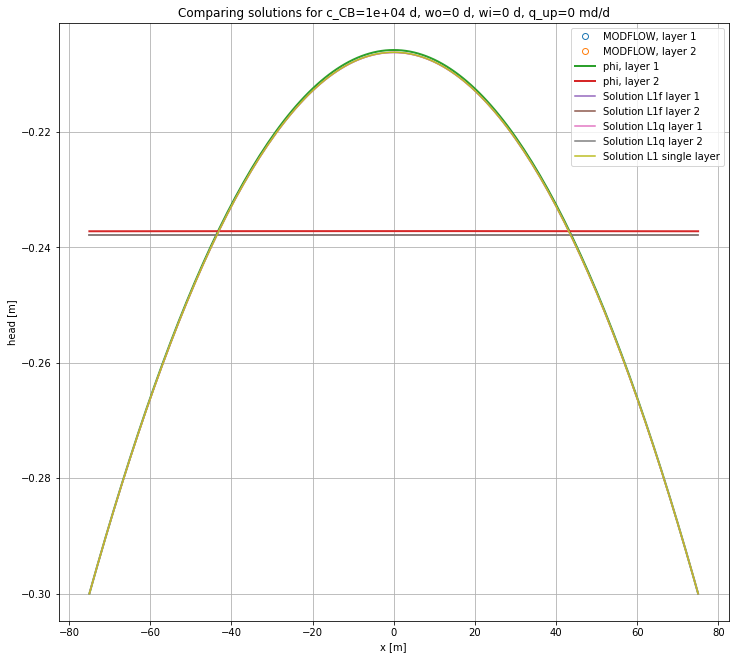

In [606]:
pdata['c_CB'] = 10000. # leakage
pdata['q_up'] = 0.     # no deepage

pdata['wo_ditch'] = 0. # no resistance (outlfow to ditch)
pdata['wi_ditch'] = 0. # no reistance (inflow from ditch)
pdata['wo_ditch2'] = np.inf # no ditches in the underlying regional aquifer
pdata['wi_ditch2'] = np.inf #no ditches in the underlying regional aquifer

# Make sure we use the specified analytical ditch resistance and not the real-world one.
use_w_not_c = True

simulate_all(dirs=dirs, props=pdata.iloc[0], tdata=tdata, dx=1.0, use_w_not_c=use_w_not_c)

## No entry/exit resistance and no net upward seepage

The only thing we change now is the resistance of the confining bed between the two aquifer. This means that there is now some exchange between the two aquifer depending on the differences between their heads. For the anlaytical two-layer solution and the numerical solution, there is even flow within the second aquifer. Due to this flow the head in the second aquifer is now somewhat curved. The head in the first aquifer is now lower than that in the of the single-layer solution due to some flow through the second aquifer. For the single layer-solution with underlying regional aquifer, only the average head in the second aquifer can be computed, and will, therefore be straigth. 

iter=0, std(hx - hk_prev) = 0.025574179971175528
iter=1, std(hx - hk_prev) = 0.0019247262252797281
iter=2, std(hx - hk_prev) = 0.00014485590726485414
iter=3, std(hx - hk_prev) = 1.0901931710564362e-05
iter=4, std(hx - hk_prev) = 8.204851101048265e-07
adding Package:  DIS
adding Package:  BAS6
Adding Steady_basic.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding Steady_basic.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python/GGOR/bin/mfusg.mac

                          

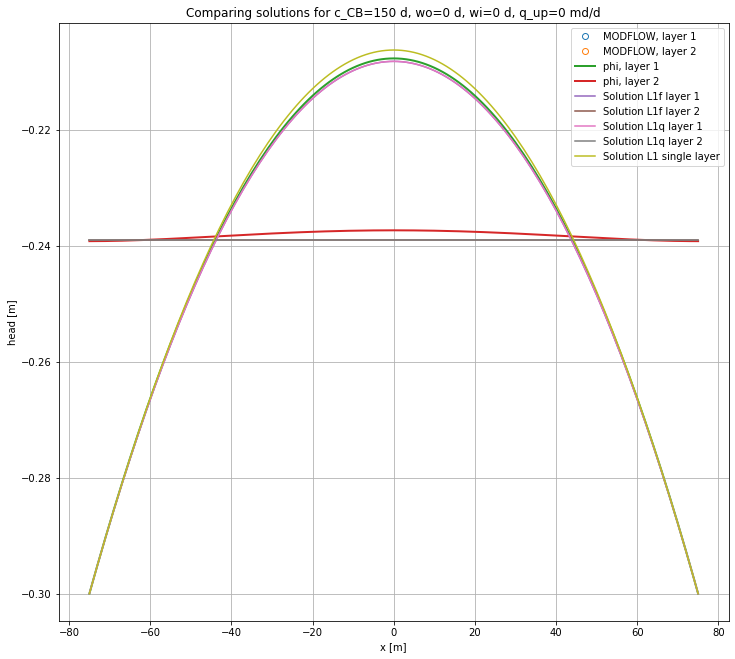

In [607]:
# With leakage
pdata['c_CB'] = 150.0 # d
props = pdata.iloc[0]

# Make sure we use the specified analytical ditch resistance and not the real-world one.
use_w_not_c = True

simulate_all(dirs=dirs, props=pdata.iloc[0], tdata=tdata, dx=1.0, use_w_not_c=use_w_not_c)

Except for the single layer, all solutions yield the same result. The MODFLOW and the analytical 2-layer solutions show that the head in the regional aquifer is curved. This is due to the flow that takes place in the regional aquifer caused by lekage. This flow is zero at both ends because closed there. The leakage follows the difference between the head in the top and regional aquifer.

## Add resistance between aquifer(s) and ditch in top aquifer

Setting the resistance between the ditch and the first aquifer to a value larger than zero causes the head at teh ends of the cross sections to change from the given water level in the ditch. 

iter=0, std(hx - hk_prev) = 0.015824076792823775
iter=1, std(hx - hk_prev) = 0.0120910846568443
iter=2, std(hx - hk_prev) = 0.00018353013932246394
iter=3, std(hx - hk_prev) = 5.378439711195457e-05
iter=4, std(hx - hk_prev) = 1.5761778329013447e-05
iter=5, std(hx - hk_prev) = 4.619065554956583e-06
adding Package:  DIS
adding Package:  BAS6
Adding Steady_basic.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding Steady_basic.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python

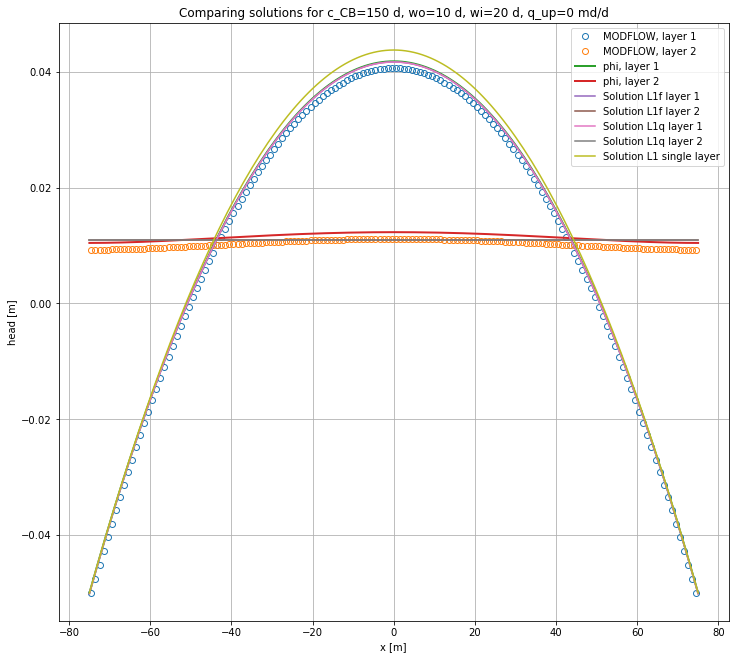

In [608]:
# Entry resistance
pdata['wo_ditch'] = 10.0
pdata['wi_ditch'] = 20.0

# Make sure we use the specified analytical ditch resistance and not the real-world one.
use_w_not_c = True

simulate_all(dirs=dirs, props=pdata.iloc[0], tdata=tdata, dx=1.0, use_w_not_c=use_w_not_c)

All solutions (except the single-layer) one have the same result. The head in the top aquifer at both ends is elevated from the ditchlevel (-0.3 m) due to the entry resistcance.

## Add upward seepage

Setting the seepage to a no-zero value will change the head in the regional aquifer to ensure the required seepage will be geneerated in the analytical and the numerical solutions.

iter=0, std(hx - hk_prev) = 0.02215370750995329
iter=1, std(hx - hk_prev) = 0.01692751851958204
iter=2, std(hx - hk_prev) = 0.000256942195051483
iter=3, std(hx - hk_prev) = 7.529815595670656e-05
iter=4, std(hx - hk_prev) = 2.2066489660624888e-05
iter=5, std(hx - hk_prev) = 6.466691776974899e-06
adding Package:  DIS
adding Package:  BAS6
Adding Steady_basic.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  GHB
adding Package:  RIV
adding Package:  DRN
adding Package:  WEL
adding Package:  RCH
adding Package:  EVT
Adding Steady_basic.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  SMS
Pakages used:[dis, bas, lpf, ghb, riv, drn, wel, rch, evt, oc, sms]

Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  GHB
   Package:  RIV
   Package:  DRN
   Package:  WEL
   Package:  RCH
   Package:  EVT
   Package:  OC
   Package:  SMS
 
FloPy is using the following  executable to run the model: /Users/Theo/GRWMODELS/python/G

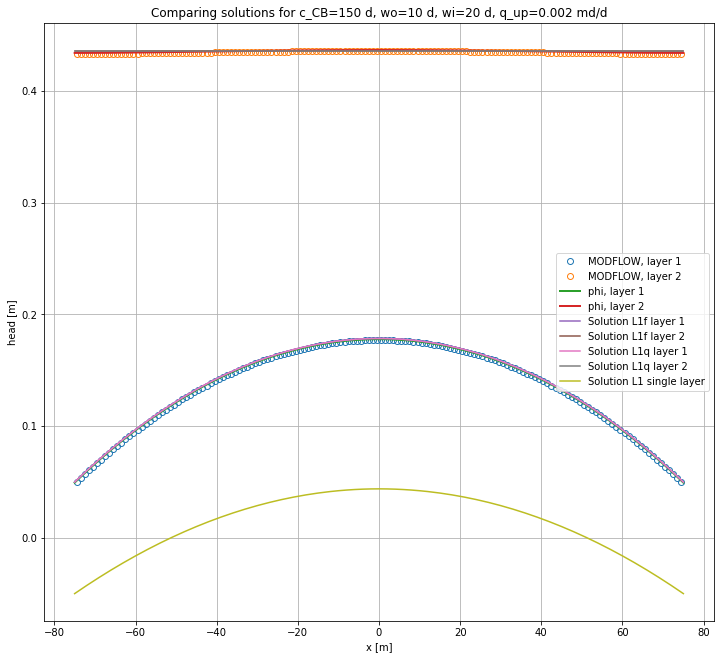

In [609]:
# Entry resistance
pdata['q_up'] = 0.002

# Make sure we use the specified analytical ditch resistance and not the real-world one.
use_w_not_c = True

simulate_all(dirs=dirs, props=pdata.iloc[0], tdata=tdata, dx=1.0, use_w_not_c=use_w_not_c)

All solutions yield the same results, except the single-layer solution, which has no underlying regional aquifer from which seepage could come. The upward seepage also causes the head in the regional aquifer to be above the head in the top aquifer.